In [2]:
import jax
import pennylane as qml
from pennylane import numpy as np
from pennylane import grad
from pennylane.fourier import circuit_spectrum
import matplotlib
import gymnasium as gym

In [55]:
@qml.qnode(dev)
def actor_qnode(n_qubits, state_input, theta, theta_par):
    # Apply Hadamard
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
    
    # RX with state-dependent angle
    for i in range(n_qubits):
        qml.RX(state_input[i], wires=i)
    
    # Entanglement (CZ between neighbours)
    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])
    
    # RY with trainable parameter
    for i in range(0, n_qubits):
        qml.RY(theta_par[i], wires=i)
    
    # Measurement
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [56]:
@qml.qnode(dev)
def critic_qnode(n_qubits, critic_input, theta, theta_par):
    # Build same ansatz as above, with critic_input
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RX(critic_input[i], wires=i)

    for i in range(n_qubits - 1):
        qml.CZ(wires=[i, i+1])

    for i in range(0, n_qubits):
        qml.RY(theta_par[i], wires=i)

    # Q-value output (e.g., Z₀ expectation)
    return [qml.expval(qml.PauliZ(0)) for i in range(n_qubits)]

In [3]:
def make_critic_qnode(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def critic_qnode(critic_input, theta, theta_par):
        # Build same ansatz as above, with critic_input
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
            qml.RX(critic_input[i], wires=i)
    
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])
    
        for i in range(0, n_qubits):
            qml.RY(theta_par[i], wires=i)
    
        # Q-value output (e.g., Z₀ expectation)
        #return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        return qml.expval(qml.PauliZ(i))
    return critic_qnode

def make_actor_qnode(n_qubits):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    @qml.qnode(dev)
    def actor_qnode(state_input, theta, theta_par):
        # Apply Hadamard
        for i in range(n_qubits):
            qml.Hadamard(wires=i)
        
        # RX with state-dependent angle
        for i in range(n_qubits):
            qml.RX(state_input[i], wires=i)
        
        # Entanglement (CZ between neighbours)
        for i in range(n_qubits - 1):
            qml.CZ(wires=[i, i+1])
        
        # RY with trainable parameter
        for i in range(0, n_qubits):
            qml.RY(theta_par[i], wires=i)
        
        # Measurement
        #return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
        return qml.expval(qml.PauliZ(i))
    return actor_qnode

In [4]:
# TODO: PROPERLY PORT THE QISKIT VERSION TO PENNYLANE
# TODO: IMPORT THE UAV LQDRL GYM ENVIRONMENT TO GET & UPDATE THESE VALUES AFTER EVERY LAYER
m_layers = 3
E_rem = 500e03
num_gus = 4
u = []
uav_pos = [0, 0, 0]
uav_v_max = 30
zeta_v = 1
uav_v = zeta_v * uav_v_max
noma_g = [1, 2, 3]
pwr_alloc = 1
action_vec = []

action_vec.append(uav_v)
for k in range(len(noma_g)):
    action_vec.append(noma_g[k])
action_vec.append(pwr_alloc)

actor_inp_vec = []
crit_inp_vec = []

for i in range(len(uav_pos)):
    actor_inp_vec.append(uav_pos[i])
actor_inp_vec.append(E_rem)
for j in range(2*num_gus):
    u.append(j)
    actor_inp_vec.append(u[j])

full_input = np.concatenate([actor_inp_vec, action_vec])

n_qubits = len(actor_inp_vec)
print(n_qubits) 
n_crit_qubits = len(full_input)
print(n_crit_qubits)

theta = np.zeros(n_qubits, requires_grad=True)
theta_par = np.random.randn(n_qubits, requires_grad=True)

crit_theta = np.zeros(n_crit_qubits, requires_grad=True)
crit_theta_par = np.random.randn(n_crit_qubits, requires_grad=True)

critic_qnode = make_critic_qnode(n_crit_qubits)
#q_val = critic_qnode(n_crit_qubits, full_input, crit_theta, crit_theta_par)
q_val = critic_qnode(full_input, crit_theta, crit_theta_par)

actor_qnode = make_actor_qnode(n_qubits)
#q_vals = actor_qnode(n_qubits, actor_inp_vec, theta, theta_par)
q_vals = actor_qnode(actor_inp_vec, theta, theta_par)

'''
# Forward pass
q_vals = actor_qnode(n_qubits, actor_inp_vec, theta, theta_par)
q_val = critic_qnode(n_crit_qubits, full_input, crit_theta, crit_theta_par)
'''

12
17


'\n# Forward pass\nq_vals = actor_qnode(n_qubits, actor_inp_vec, theta, theta_par)\nq_val = critic_qnode(n_crit_qubits, full_input, crit_theta, crit_theta_par)\n'

(<Figure size 1700x1300 with 1 Axes>, <Axes: >)

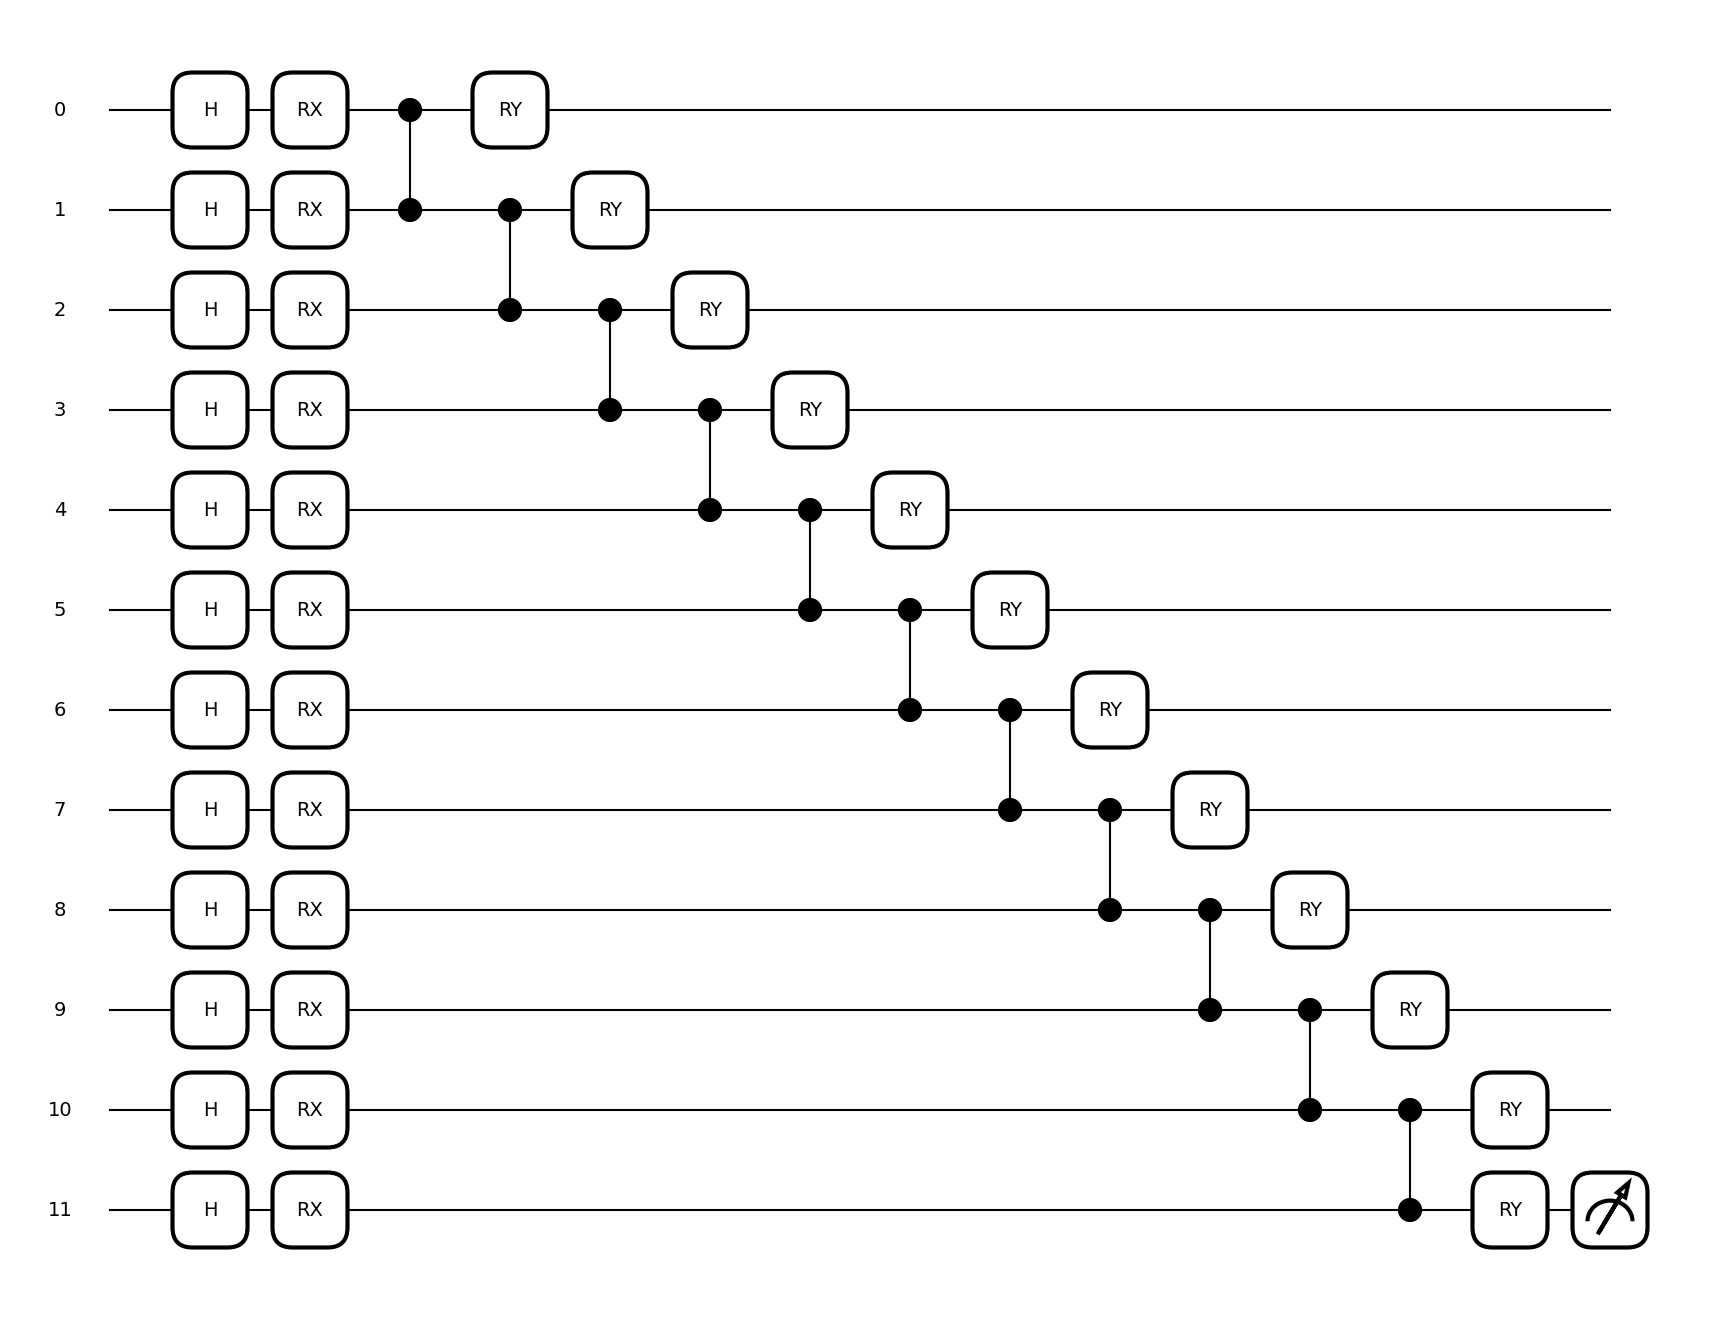

In [5]:
qml.draw_mpl(actor_qnode)(np.ones(n_qubits), np.ones(n_qubits), np.ones(n_qubits))
#qml.draw(actor_qnode)(n_qubits, np.ones(n_qubits), np.ones(n_qubits), np.ones(n_qubits))

(<Figure size 2200x1800 with 1 Axes>, <Axes: >)

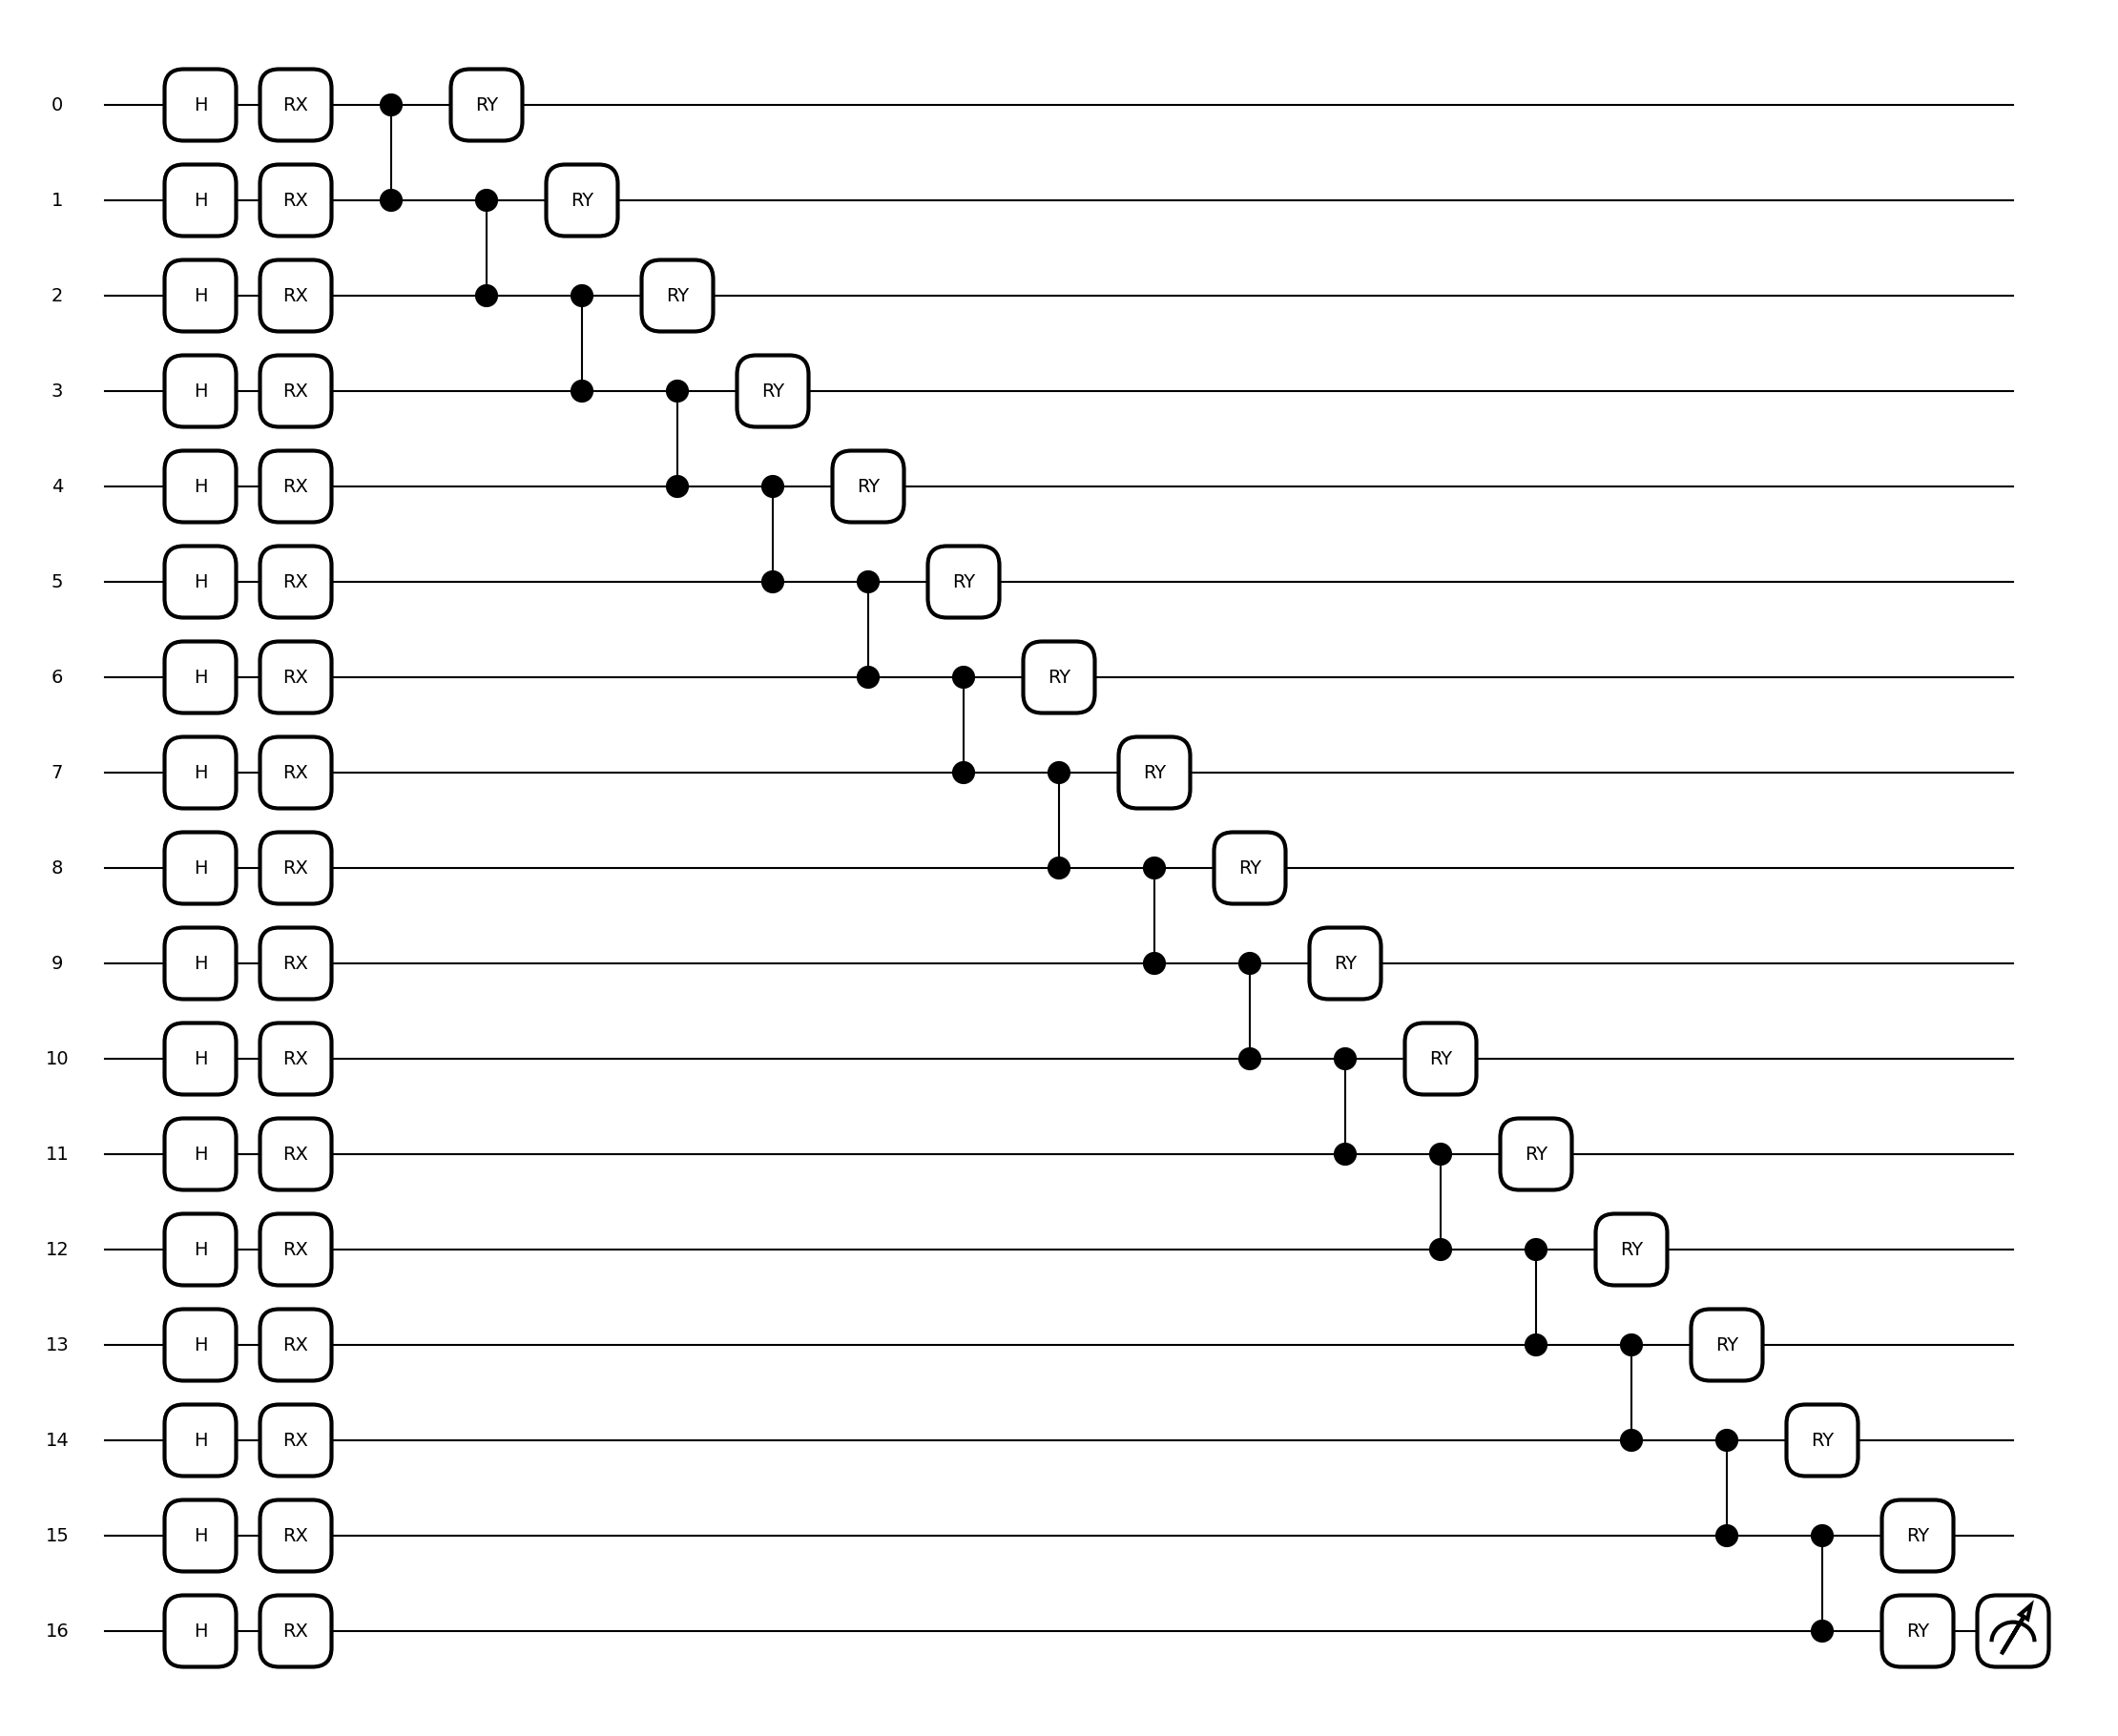

In [6]:
qml.draw_mpl(critic_qnode)(np.ones(n_crit_qubits), np.ones(n_crit_qubits), np.ones(n_crit_qubits))

In [7]:
actor_grad_fn = qml.grad(actor_qnode, argnum=2)
grad_vals = actor_grad_fn(actor_inp_vec, theta, theta_par)
print(grad_vals)

[-3.64923690e-21 -3.74860528e-18 -5.47591629e-18 -2.75186882e-18
 -3.57987809e-18  3.78025817e-18 -5.02778357e-18  5.01058882e-19
  3.48045907e-19  2.13174247e-18 -1.59598629e-17  1.05736024e-15]


In [8]:
critic_grad_fn = qml.grad(critic_qnode, argnum=2)
grad_vals = critic_grad_fn(full_input, crit_theta, crit_theta_par)
print(grad_vals)

[ 5.24039664e-19  7.88798995e-19  8.59614977e-20 -1.57192994e-18
  7.13327629e-20 -9.03891569e-19 -4.11380681e-19 -2.56565541e-18
 -2.66992411e-19 -4.01281433e-19  7.31843169e-19 -3.59247512e-19
  4.29953814e-19  1.17073579e-18 -3.92374006e-20  2.57439697e-19
  4.89368314e-17]


In [9]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)
for _ in range(10):
    theta_par, loss = opt.step_and_cost(lambda tp: -critic_qnode(full_input, crit_theta, tp), crit_theta_par)
    print("Loss:", loss)

Loss: -1.3322676295501878e-15
Loss: -1.3322676295501878e-15
Loss: -1.3322676295501878e-15
Loss: -1.3322676295501878e-15
Loss: -1.3322676295501878e-15
Loss: -1.3322676295501878e-15
Loss: -1.3322676295501878e-15
Loss: -1.3322676295501878e-15
Loss: -1.3322676295501878e-15
Loss: -1.3322676295501878e-15


In [ ]:
# TODO: Implement updating the theta parameter for the RY gates 
# TODO: Implement updating the x input data vector for the RX gates based on the values stored in the Memory Experience Relay
#num_eps = 10
#for i in range(num_eps):
    

In [21]:
%load_ext autoreload
%autoreload 2
from uav_lqdrl_env import UAV_LQDRL_Environment
from quantum_models import QuantumActor, QuantumCritic

env = UAV_LQDRL_Environment()
obs, _ = env.reset()

num_episodes = 100

# Setup actor and critic
n_qubits_actor = len(obs)
print(n_qubits_actor) 
m_layers = 3
actor = QuantumActor(n_qubits=n_qubits_actor, m_layers=m_layers)

# Placeholder for critic input: obs + action (can be dynamic)
n_qubits_critic = n_qubits_actor + 5
print(n_qubits_critic) 
critic = QuantumCritic(n_qubits=n_qubits_critic, m_layers=m_layers)

for episode in range(num_episodes):
    obs, _ = env.reset()
    done = False
    while not done:
        action_vec = actor(obs)
        # Map output to environment action space [-1, 1]
        action = np.tanh(action_vec[:5])
        next_obs, reward, done, _, _ = env.step(action)
        q_val = critic(np.concatenate([obs, action]))

        # TODO: Apply gradient updates, use replay buffer, etc.

        obs = next_obs


print("All good so far")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
12
17
All good so far
